In [72]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [73]:
device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
device

'mps'

# Convolutional model dissection

The notebook is classic dissection excercise of looking inside CNN.  
We're going to use a simple architecture and train for highly biased synthetic data in order to accentuate how CNN learns patterns.  
It will be single-batch training. The architecture is based on the popular approach:  
- CNN with kernel size of 3, stride 1 and padding to preserve the dimensions
- Relu
- MaxPool with kernel size of 2 and stride 2

Then data will be flattened and forwarded into regression/classification Dense layer.  
There are going to be 2 such layers with increasing size of channels: [4, 8].  
Additionally, we'll implement additional utility method to return outputs for each filter map, to visualize activations.  

Model will be re-trained for few examples to observe the differences:
- single symbol in the middle - 99 Gaussian Noise samples + single sample with dummy feature
- single symbol in different corners - 91 Gaussian Noise samples + 9 samples with dummy feature
- two symbols in different corners - 9 samples with one symbol, 9 samples with another and 82 Gaussian Noise samples

For single symbol will be used regression model, for two symbols classification.  
Both using standard optimizers and loss functions configuration (Sigmoid->MSELoss for regression and LogSoftmax+NLLLoss->RMSProp for classification).

We're going to visualize:
- CNN filter weights 
- activations of the filter maps for significant samples
- heatmap for training data



## Model architecture

In [148]:
class CNNModule(torch.nn.Module):
    def __init__(self, output_classes=None) -> None:
        super().__init__()

        self.cnn_layer1 = torch.nn.Conv2d(1, 4, kernel_size=3, stride=1, bias=False, padding=1)
        self.max_pool1 = torch.nn.MaxPool2d(2, 2)
        self.cnn_layer2 = torch.nn.Conv2d(4, 8, kernel_size=3, stride=1, bias=False, padding=1)
        self.max_pool2 = torch.nn.MaxPool2d(2, 2)
        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(8*4*4, 128)
        self.output_activation = None
        if output_classes:
            self.linear_out = torch.nn.Linear(128, output_classes)
            self.output_activation = torch.nn.LogSoftmax(dim=1)
        else:
            self.linear_out = torch.nn.Linear(128, 1)
            self.output_activation = torch.nn.Sigmoid()

    def forward(self, x):
        # CNN
        logits = self.cnn_layer1(x)
        logits = torch.relu(logits)
        logits = self.max_pool1(logits)

        logits = self.cnn_layer2(logits)
        logits = torch.relu(logits)
        logits = self.max_pool2(logits)

        # classification
        logits = self.flatten(logits)
        logits = self.linear1(logits)
        logits = torch.relu(logits)

        # output
        logits = self.linear_out(logits)
        if self.output_activation:
            logits = self.output_activation(logits)
        return logits

    def extract_features(self, x):
        # Define the forward pass
        intermediate_outputs = {}

        for name, layer in self.named_children():
            x = layer(x)
            if layer.__class__.__name__ in ["Conv2d", "MaxPool2d"]:
                print(f"extracting: {layer.__class__.__name__}")
                intermediate_outputs[name] = x

        print(f"extracting: {layer.__class__.__name__}")
        intermediate_outputs[name] = x
        return intermediate_outputs

    def classify_features_activations(self, logits):

        # last max_pool
        logits = self.self.max_pool2(logits)

        # classification
        logits = self.flatten(logits)
        logits = self.linear1(logits)
        logits = torch.relu(logits)

        # output
        logits = self.linear_out(logits)
        if self.output_activation:
            logits = self.output_activation(logits)
        return logits



In [75]:
class CustomDataset(Dataset):
    def __init__(self, data_inputs, data_labels, dtype=torch.float32):
        self.inputs = data_inputs
        self.labels = data_labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        X = self.inputs[idx]
        Y = self.labels[idx]
        return X, Y

## Dataset scenarios

### 1st scenario - single symbol in fixed place

Define DS
We're generating one sample with "X" symbol, the rest will contain Gaussian noise.  

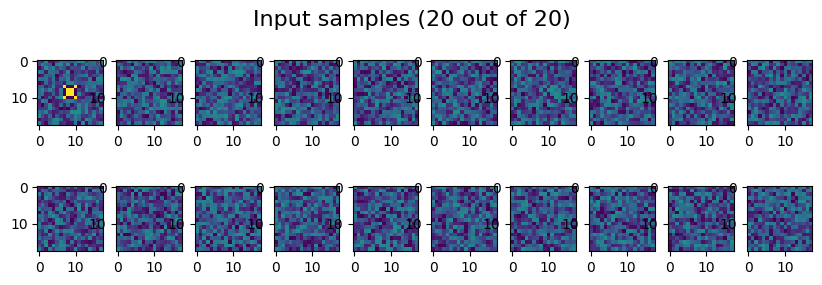

In [76]:
ds_size = 20
symbol_0 = torch.tensor([
                         [1, 0, 0, 1],
                         [0, 1, 1, 0],
                         [0, 1, 1, 0],
                         [1, 0, 0, 1]])
X = (torch.rand((ds_size, 18, 18)))/2
Y = torch.zeros((ds_size, 1))

# include single symbol in half of the  samples
X[0, 7:11, 7:11] = symbol_0
Y[0] = 1

# dataloader
dataset = CustomDataset(X, Y)
dataloader = DataLoader(dataset, batch_size=ds_size, shuffle=True)

# print first few input samples
print_sample_rows = 2
print_sample_columns = 10
def print_samples(X, print_sample_rows, print_sample_columns):
    x_nograd = X.cpu().detach().numpy()
    fig, ax = plt.subplots(print_sample_rows, print_sample_columns, figsize=(10, 3))
    fig.suptitle(f"Input samples ({print_sample_columns*print_sample_rows} out of {len(X)})", fontsize=16)
    for i in range(print_sample_rows):
        for j in range(print_sample_columns):
            ax[i][j].imshow(x_nograd[print_sample_columns*i+j], vmin=0, vmax=1)

print_samples(X, print_sample_rows, print_sample_columns)

Train

In [77]:
model = CNNModule().to(device)
loss_fn = torch.nn.MSELoss()
optim = torch.optim.AdamW(model.parameters(), lr=1e-3)
epochs = 1000

for epoch in range(epochs):
    for id, (x, y) in enumerate(dataloader):
        x = x.view(-1, 1, 18, 18)
        x = x.to(device)
        y = y.to(device)

        optim.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y, y_pred)
        loss.backward()
        optim.step()

    if epoch%100 == 99 and epoch != 0:
        print(f"Epoch {epoch}, loss: {loss.item()}")

Epoch 99, loss: 0.047023870050907135
Epoch 199, loss: 0.00014035550702828914
Epoch 299, loss: 3.065361670451239e-05
Epoch 399, loss: 1.2524827980087139e-05
Epoch 499, loss: 6.842930361017352e-06
Epoch 599, loss: 4.350702056399314e-06
Epoch 699, loss: 3.031043888768181e-06
Epoch 799, loss: 2.245215227958397e-06
Epoch 899, loss: 1.7366645579386386e-06
Epoch 999, loss: 1.3877644278181833e-06


In [78]:
print("Model layer stack:")
model.named_parameters

Model layer stack:


<bound method Module.named_parameters of CNNModule(
  (cnn_layer1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn_layer2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=128, out_features=128, bias=True)
  (linear_out): Linear(in_features=128, out_features=1, bias=True)
  (output_activation): Sigmoid()
)>

Conv layer weights

Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


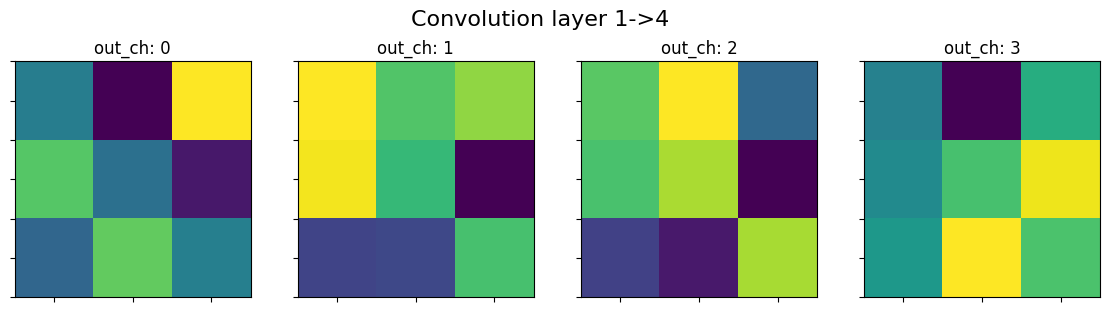

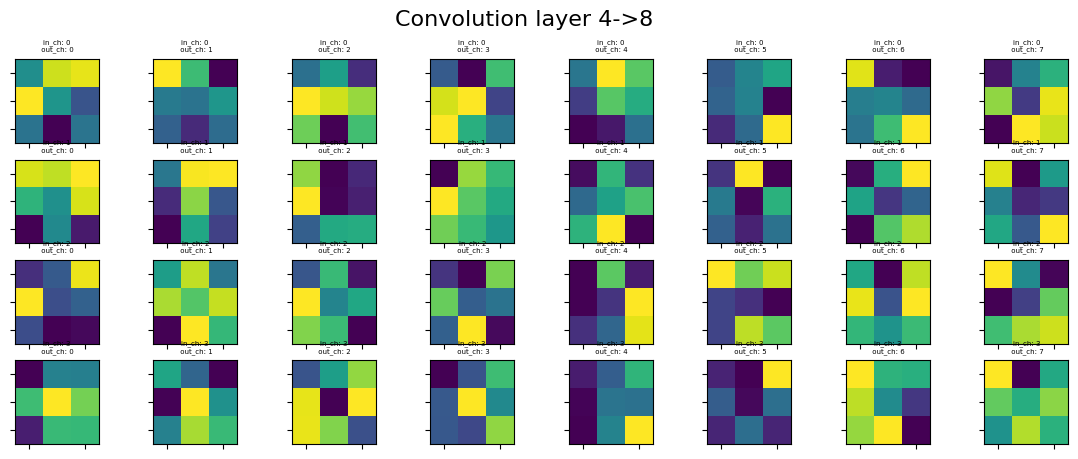

In [79]:
def display_cnn_layer(layer):
    with torch.no_grad():
        layer_shape = next(iter(layer.parameters())).shape
        out_channels_num = layer_shape[0]
        inp_channels_num = layer_shape[1]
        print(layer)
        fig, ax = plt.subplots(inp_channels_num, out_channels_num)
        fig.suptitle(f"Convolution layer {inp_channels_num}->{out_channels_num}", fontsize=16)
        fig.set_size_inches(14, 1+inp_channels_num)
        weights = list(layer.parameters())[0]
        for out_cid, channel in enumerate(weights):
            if inp_channels_num > 1:
                for inp_cid, inp_channel in enumerate(channel):
                    ax[inp_cid][out_cid].imshow(inp_channel.squeeze().cpu())
                    ax[inp_cid][out_cid].set_title(f"in_ch: {inp_cid}\n out_ch: {out_cid}", fontsize=5)
                    ax[inp_cid][out_cid].set_yticklabels([])
                    ax[inp_cid][out_cid].set_xticklabels([])
            else:
                fig.set_size_inches(14, 3.5)
                for inp_cid, inp_channel in enumerate(channel):
                    ax[out_cid].imshow(channel.squeeze().cpu())
                    ax[out_cid].set_title(f"out_ch: {out_cid}")
                    ax[out_cid].set_yticklabels([])
                    ax[out_cid].set_xticklabels([])


display_cnn_layer(model.cnn_layer1)
display_cnn_layer(model.cnn_layer2)

In [80]:
# print all layers
for name, layer in model.named_children():
    print(f"{name}: ", layer.__class__.__name__)

cnn_layer1:  Conv2d
max_pool1:  MaxPool2d
cnn_layer2:  Conv2d
max_pool2:  MaxPool2d
flatten:  Flatten
linear1:  Linear
linear_out:  Linear
output_activation:  Sigmoid


extracting: Conv2d
extracting: MaxPool2d
extracting: Conv2d
extracting: MaxPool2d
extracting: LogSoftmax


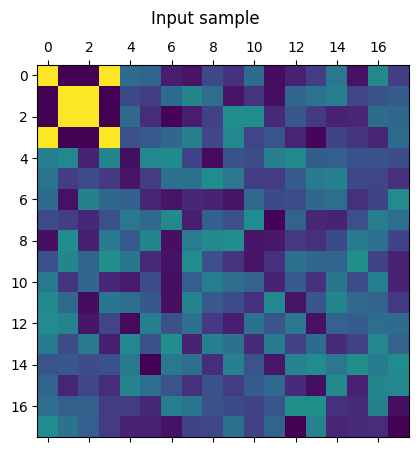

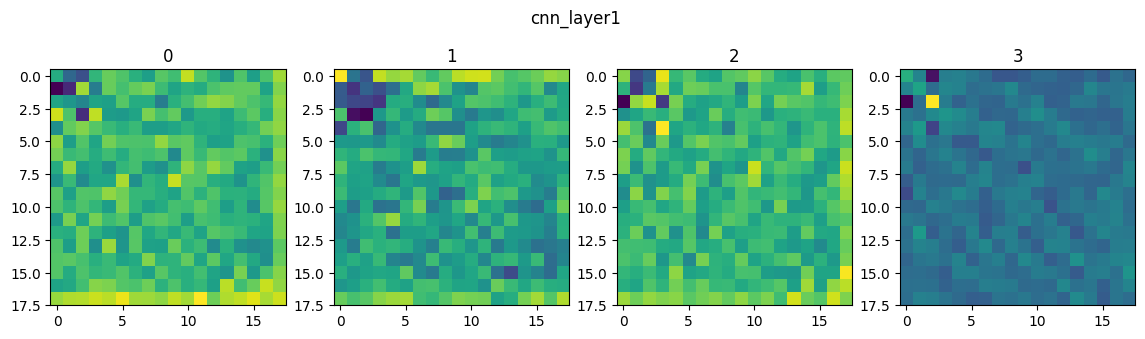

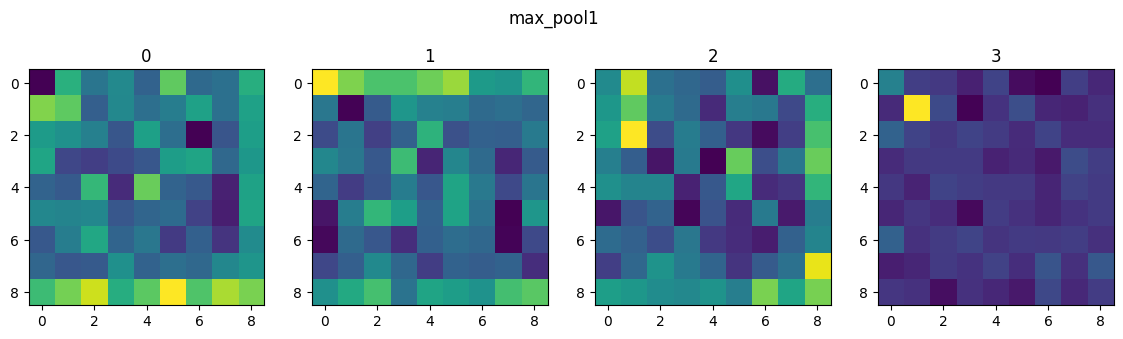

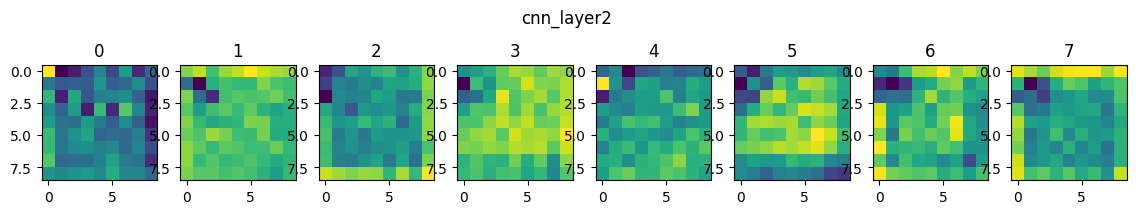

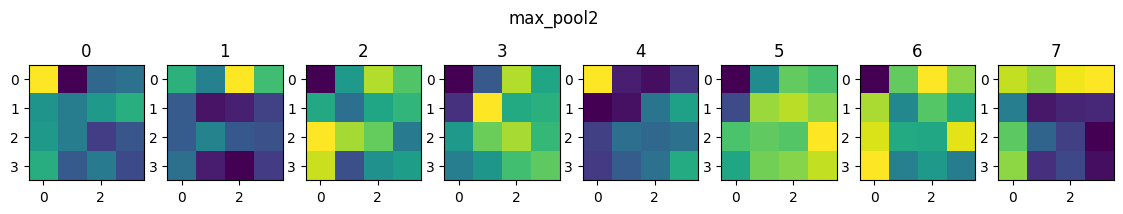

extracting: Conv2d
extracting: MaxPool2d
extracting: Conv2d
extracting: MaxPool2d
extracting: LogSoftmax


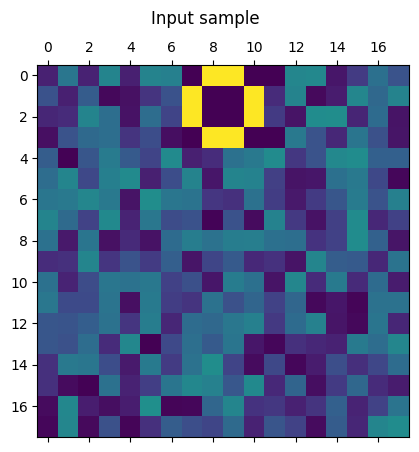

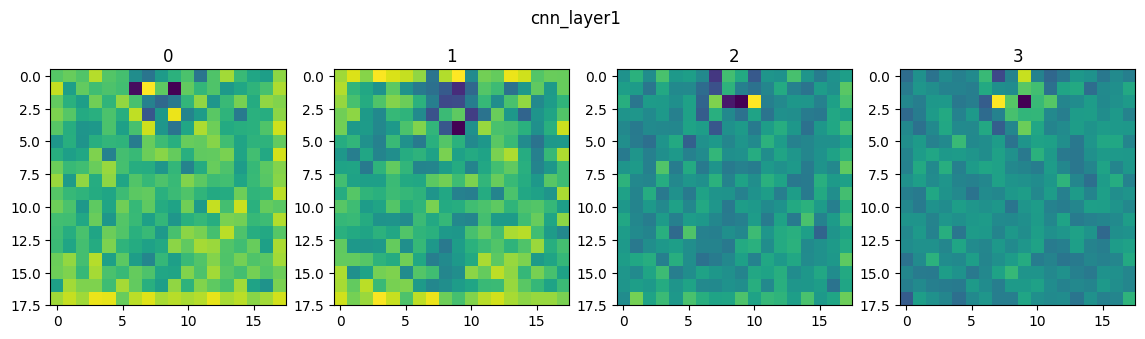

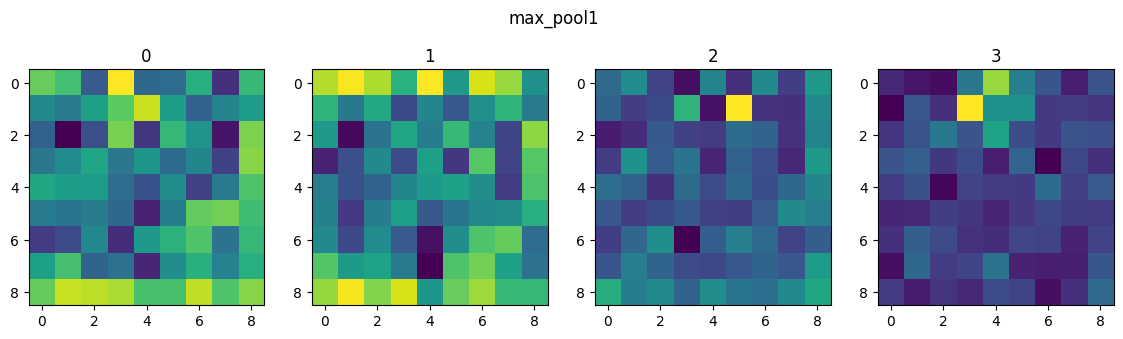

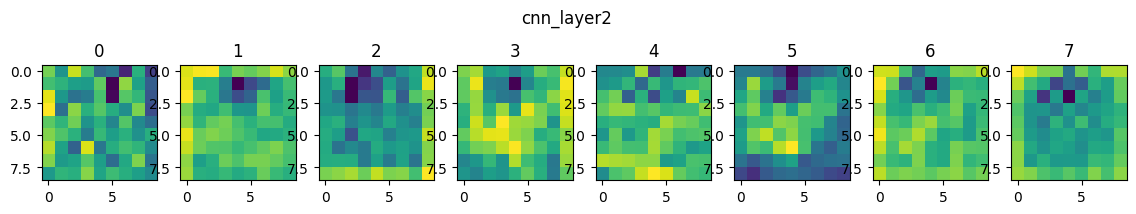

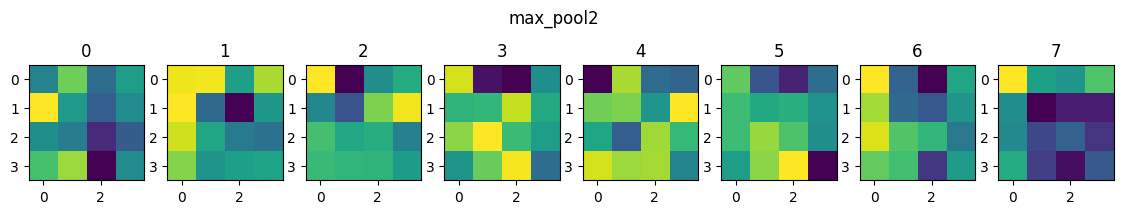

In [128]:
# util function for feature map
def display_feature_maps(sample, output_features):
    #print(output_features)
    output_features = {name: feat for name, feat in output_features.items() if name != 'output_activation'}
    plt.matshow(sample.cpu().detach().numpy(), vmin=0, vmax=1)
    plt.suptitle('Input sample', fontsize=12)
    for layer_id, item in enumerate(output_features.items()):
        name, layer_tensors = item[0], item[1].cpu().detach().squeeze(dim=0).numpy()
        fig, ax = plt.subplots(1, layer_tensors.shape[0])
        fig.suptitle(name, fontsize=12)
        fig.set_size_inches(14, np.max([1.0, 5.0-(len(layer_tensors)/3)])) # this size is arbitrary, it might break if you try to add more layers
        for tid, tensor in enumerate(layer_tensors):
            ax[tid].imshow(tensor)
            ax[tid].axes.set_title(tid)

    plt.show()

samples = [X[0], X[10]]
for sample in samples:
    # generate activations only for Conv2d and MaxPool2d layers
    output_features = model.extract_features(sample.unsqueeze(dim=0).unsqueeze(dim=0).to(device))
    display_feature_maps(sample, output_features)

### 2nd scenario - single symbol in different places

Define DS  
We're generating 9 samples with symbol "X", the rest will contain Gaussian noise.  

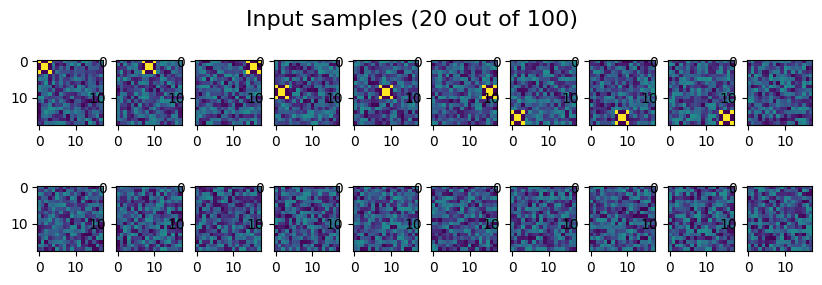

In [129]:
# generate random samples
X = (torch.rand((ds_size, 18, 18)))/2
Y = torch.zeros((ds_size, 1))

# include same symbol in different pleaces
for i in range(3):
    for j in range(3):
        X[3*i+j, (i*6+(i)):(i*6+(i)+4), (j*6+(j)):(j*6+(j)+4)] = symbol_0
        Y[3*i+j] = 1

# dataloader
dataset = CustomDataset(X, Y)
dataloader = DataLoader(dataset, batch_size=ds_size, shuffle=True)

print_samples(X, print_sample_rows, print_sample_columns)

Train

In [130]:
model = CNNModule().to(device)
loss_fn = torch.nn.MSELoss()
optim = torch.optim.AdamW(model.parameters(), lr=1e-2)
epochs = 2000

for epoch in range(epochs):
    for id, (x, y) in enumerate(dataloader):
        x = x.view(-1, 1, 18, 18)
        x = x.to(device)
        y = y.to(device)

        optim.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y, y_pred)
        loss.backward()
        optim.step()

    if epoch%200 == 199 and epoch != 0:
        print(f"Epoch {epoch}, loss: {loss.item()}")

Epoch 199, loss: 0.08999999612569809
Epoch 399, loss: 0.08999999612569809
Epoch 599, loss: 0.08999999612569809
Epoch 799, loss: 0.08999999612569809
Epoch 999, loss: 0.08999999612569809
Epoch 1199, loss: 0.08999999612569809
Epoch 1399, loss: 0.08999999612569809
Epoch 1599, loss: 0.08999999612569809
Epoch 1799, loss: 0.08999999612569809
Epoch 1999, loss: 0.08999999612569809


Conv layer weights

Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


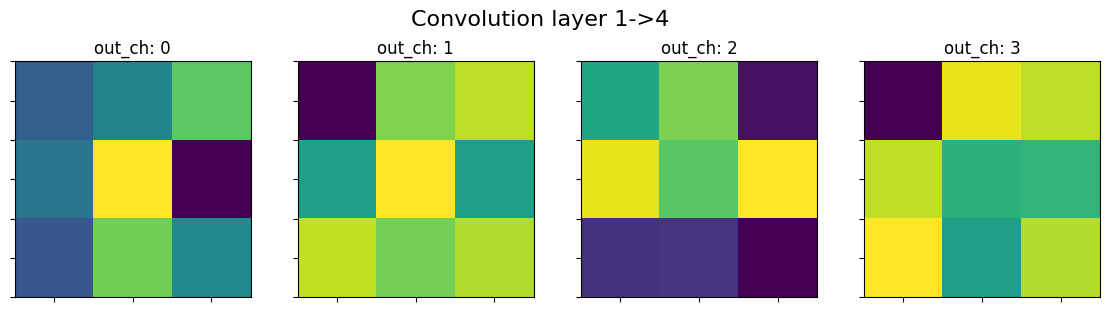

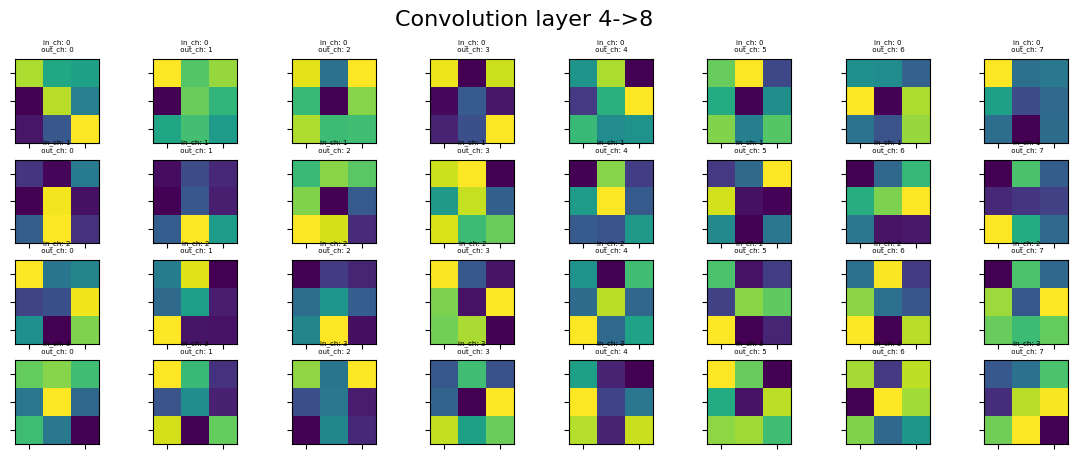

In [131]:
display_cnn_layer(model.cnn_layer1)
display_cnn_layer(model.cnn_layer2)

extracting: Conv2d
extracting: MaxPool2d
extracting: Conv2d
extracting: MaxPool2d
extracting: Sigmoid


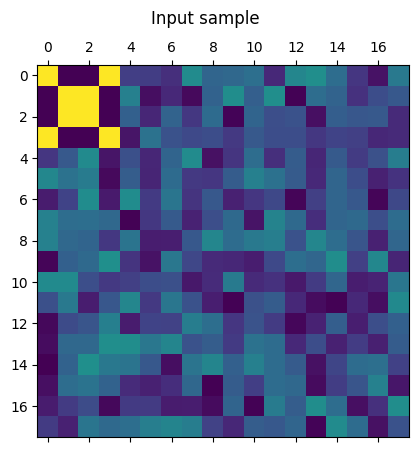

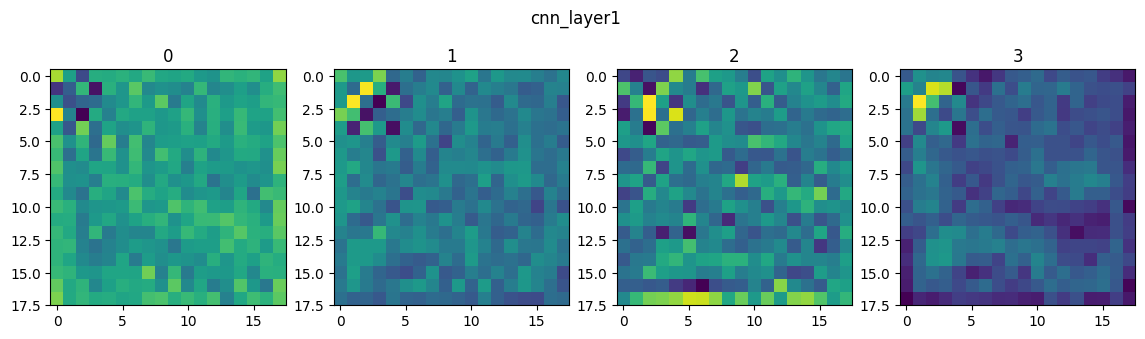

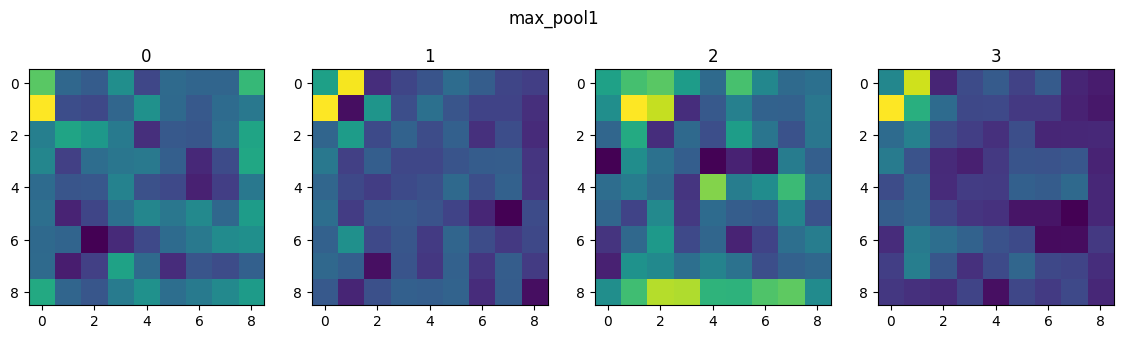

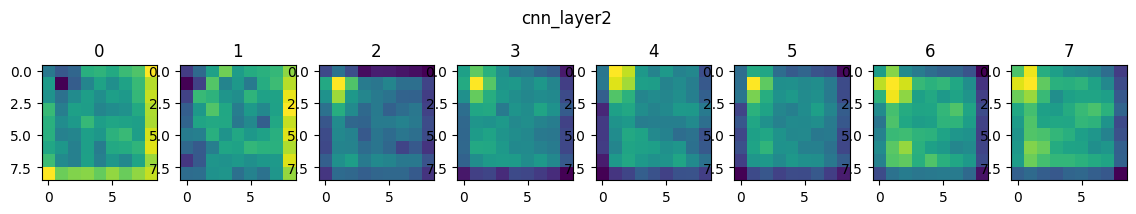

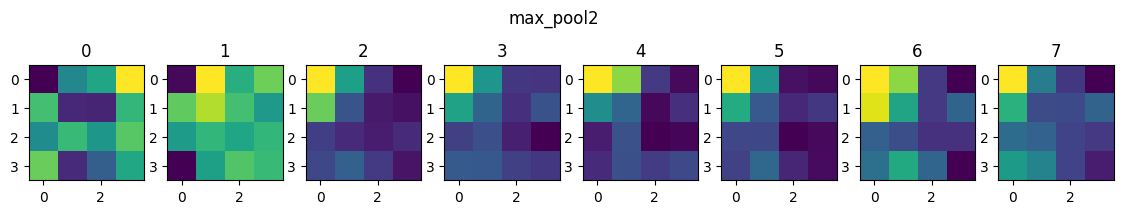

extracting: Conv2d
extracting: MaxPool2d
extracting: Conv2d
extracting: MaxPool2d
extracting: Sigmoid


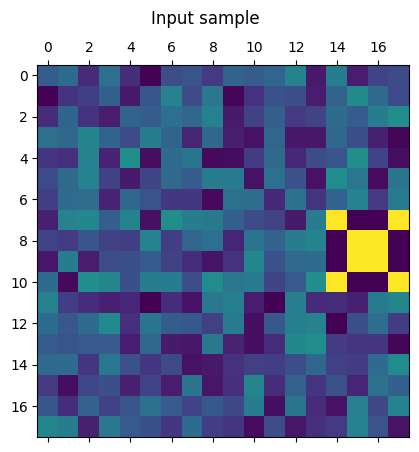

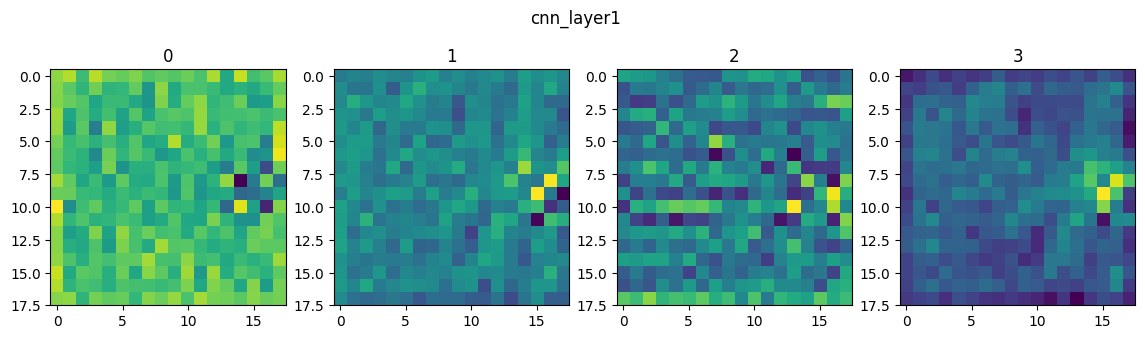

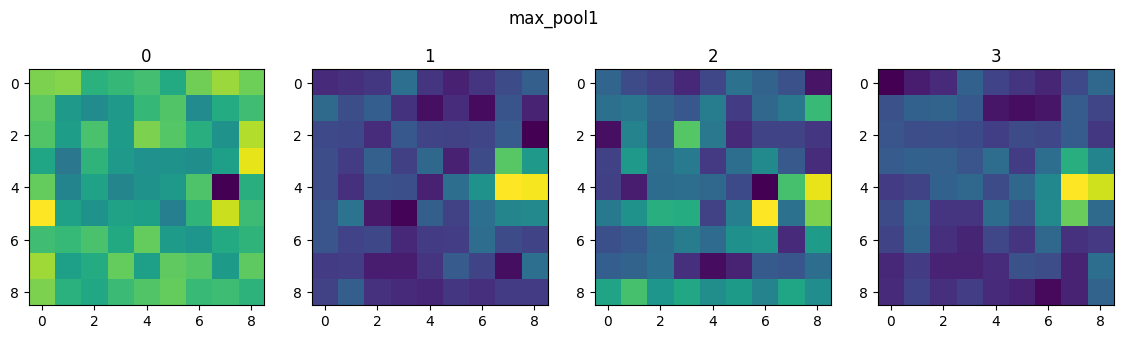

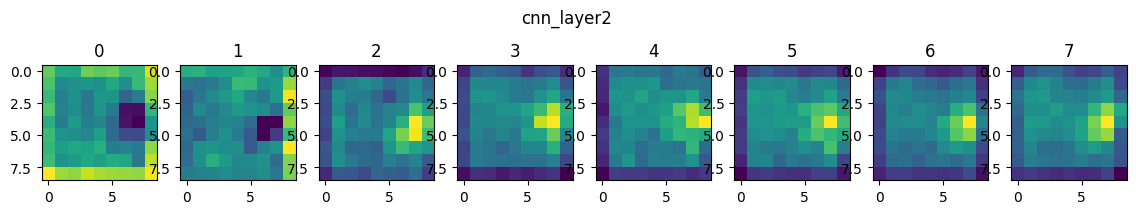

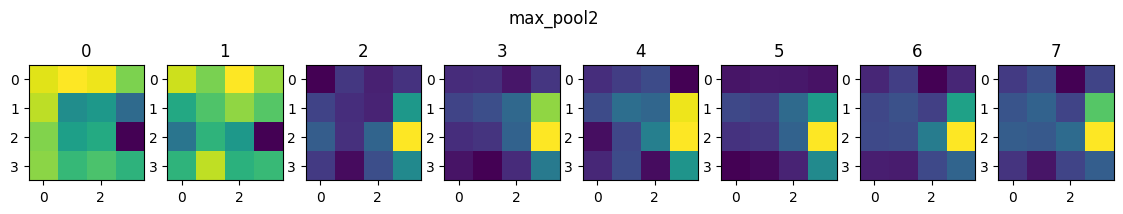

extracting: Conv2d
extracting: MaxPool2d
extracting: Conv2d
extracting: MaxPool2d
extracting: Sigmoid


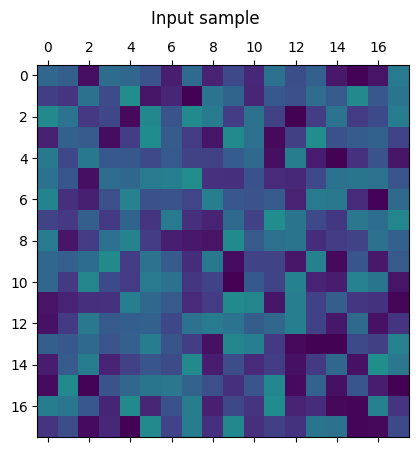

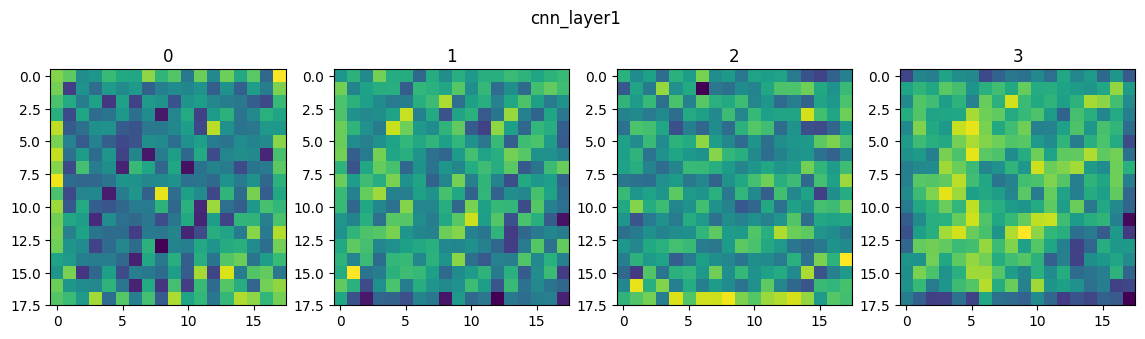

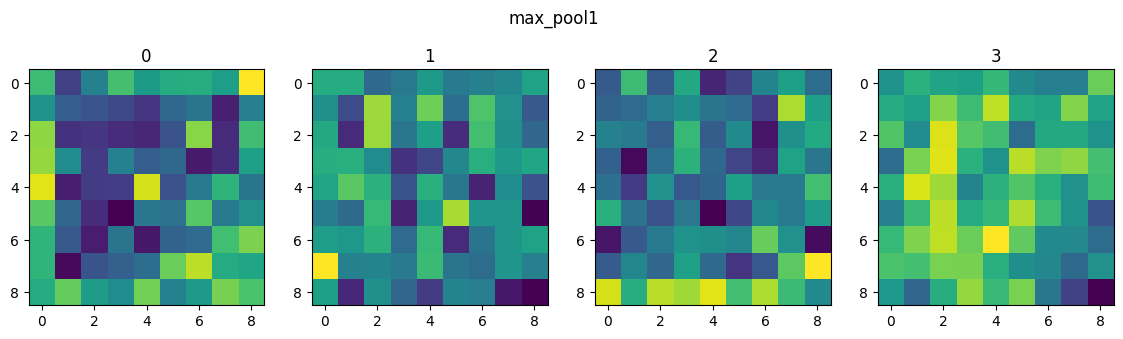

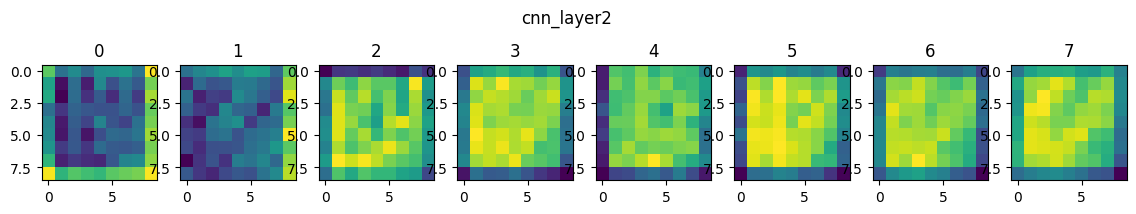

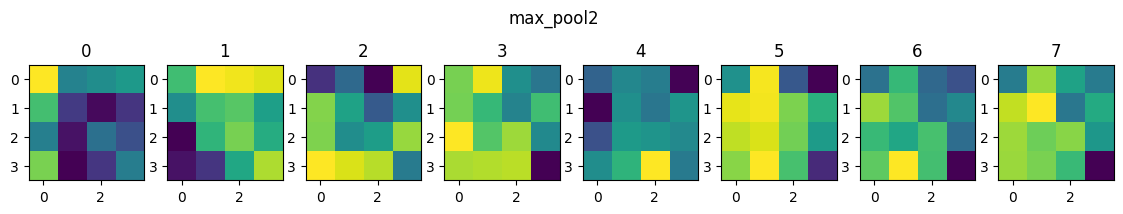

In [132]:
samples = [X[0], X[5], X[10]]
for sample in samples:
    # generate activations only for Conv2d and MaxPool2d layers
    output_features = model.extract_features(sample.unsqueeze(dim=0).unsqueeze(dim=0).to(device))
    display_feature_maps(sample, output_features)

### 3rd scenario - two symbols (two classes)

Define DS  
We're generating 9 samples with symbol "X" and 9 samples with symbol "O", the rest will contain Gaussian noise.  

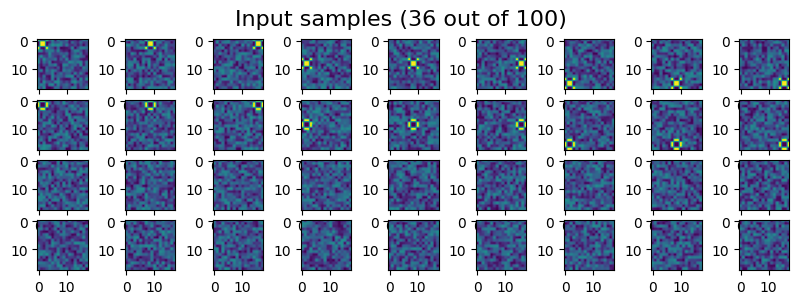

In [173]:
symbol_1 = torch.tensor([
                         [0, 1, 1, 0],
                         [1, 0, 0, 1],
                         [1, 0, 0, 1],
                         [0, 1, 1, 0]])

# generate random samples
ds_size = 100
num_classes = 3
X = (torch.rand((ds_size, 18, 18), requires_grad=True))/2
Y = torch.zeros(ds_size)

# include X symbol
for i in range(3):
    for j in range(3):
        X[3*i+j, (i*6+(i)):(i*6+(i)+4), (j*6+(j)):(j*6+(j)+4)] = symbol_0
        Y[3*i+j] = torch.tensor([1])

# include O symbol
for i in range(3):
    for j in range(3):
        X[3*i+j+9, (i*6+(i)):(i*6+(i)+4), (j*6+(j)):(j*6+(j)+4)] = symbol_1
        Y[3*i+j+9] = torch.tensor([2])

# dataloader
dataset = CustomDataset(X, Y)
dataloader = DataLoader(dataset, batch_size=ds_size, shuffle=False)

print_samples(X, 4, 9)

Train

In [183]:
model = CNNModule(output_classes=3).to(device)
# NNLoss with balancing parameters
loss_fn = torch.nn.NLLLoss(torch.tensor([0.8, 0.1, 0.1], device=device, requires_grad=False))
optim = torch.optim.RMSprop(model.parameters(), lr=1e-2)
epochs = 5000

for epoch in range(epochs):
    for id, (x, y) in enumerate(dataloader):
        x = x.view(-1, 1, 18, 18)
        x = x.to(device)
        y = y.to(device)

        optim.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward(retain_graph=True)
        optim.step()

    if epoch%200 == 199:
        print(f"Epoch {epoch}, loss: {loss.item()}")

Epoch 199, loss: 0.0003676401684060693
Epoch 399, loss: 2.0298539311625063e-05
Epoch 599, loss: 4.240271664457396e-06
Epoch 799, loss: 1.1131985502288444e-06
Epoch 999, loss: 3.1570914416079177e-07
Epoch 1199, loss: 9.1971472215846e-08
Epoch 1399, loss: 2.5469038433811875e-08
Epoch 1599, loss: 4.598576630598927e-09
Epoch 1799, loss: 1.4149469373947454e-09
Epoch 1999, loss: 0.0
Epoch 2199, loss: 0.0
Epoch 2399, loss: 0.0
Epoch 2599, loss: 0.0
Epoch 2799, loss: 0.0
Epoch 2999, loss: 0.0
Epoch 3199, loss: 6.5306335272907745e-06
Epoch 3399, loss: 1.2959352488906006e-06
Epoch 3599, loss: 6.163677426229697e-07
Epoch 3799, loss: 4.0184107774621225e-07
Epoch 3999, loss: 2.7520596290742105e-07
Epoch 4199, loss: 1.5405201736484742e-07
Epoch 4399, loss: 7.693766690408665e-08
Epoch 4599, loss: 2.7237723188022755e-08
Epoch 4799, loss: 1.2203916988084984e-08
Epoch 4999, loss: 3.5373672879757123e-09


In [192]:
# evaluate
y_pred = model(X.view(-1, 1, 18, 18).to(device))
y_pred_argmax = torch.argmax(y_pred, dim=1)
correct = 0
for y_pred, y in zip(y_pred_argmax, Y):
    if y_pred == y:
        correct += 1
print(correct/len(Y)*100)

100.0


Conv layer weights

In [ ]:
display_cnn_layer(model.cnn_layer1)
display_cnn_layer(model.cnn_layer2)

extracting: Conv2d
extracting: MaxPool2d
extracting: Conv2d
extracting: MaxPool2d
extracting: LogSoftmax


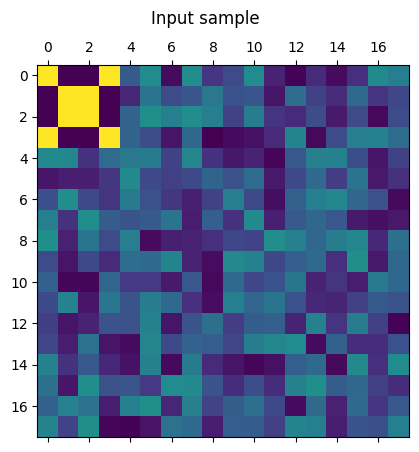

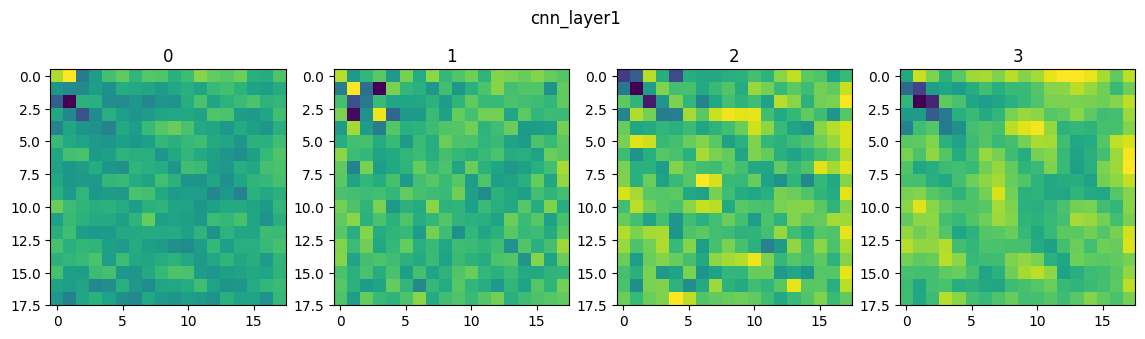

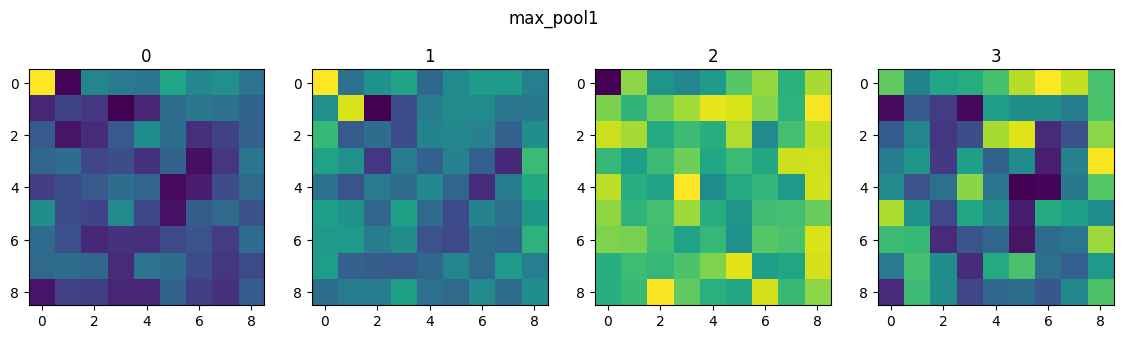

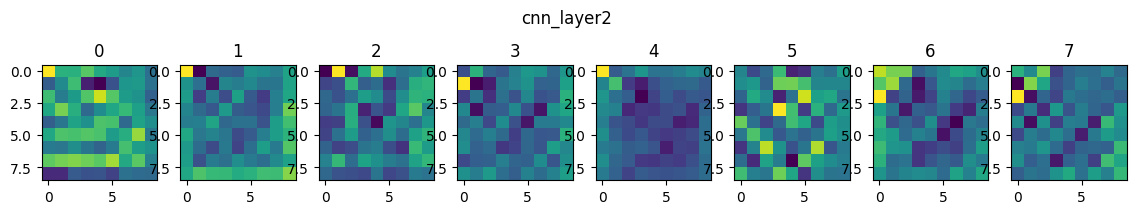

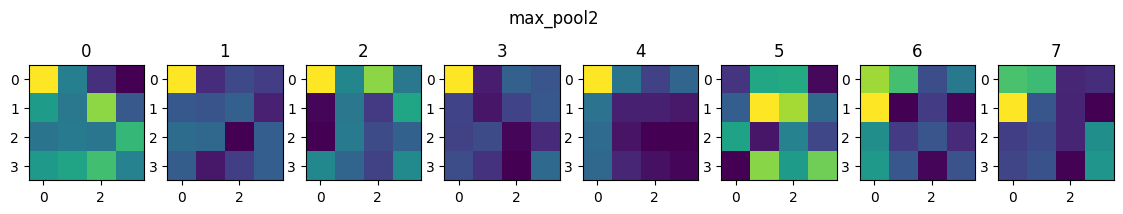

extracting: Conv2d
extracting: MaxPool2d
extracting: Conv2d
extracting: MaxPool2d
extracting: LogSoftmax


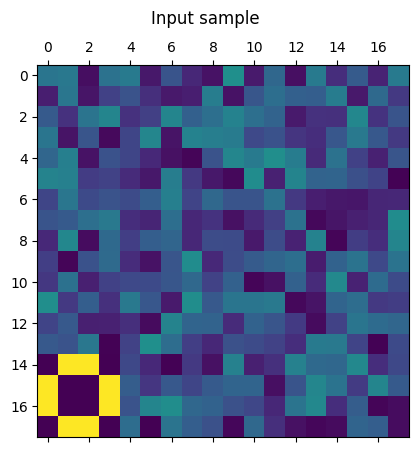

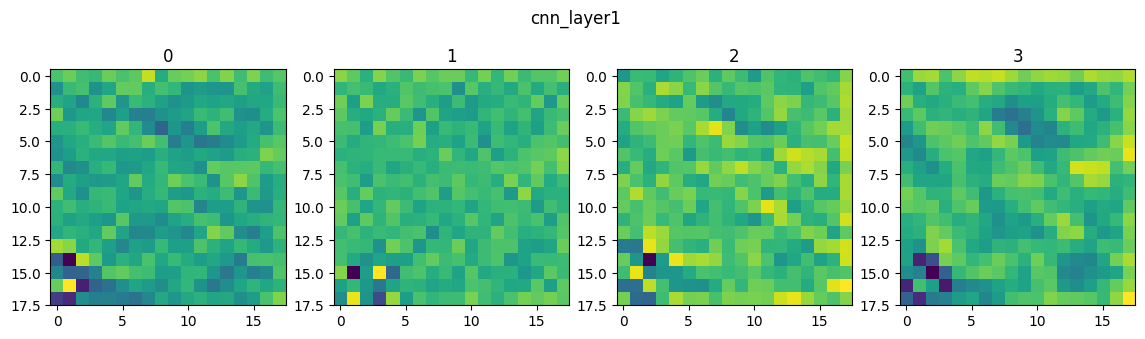

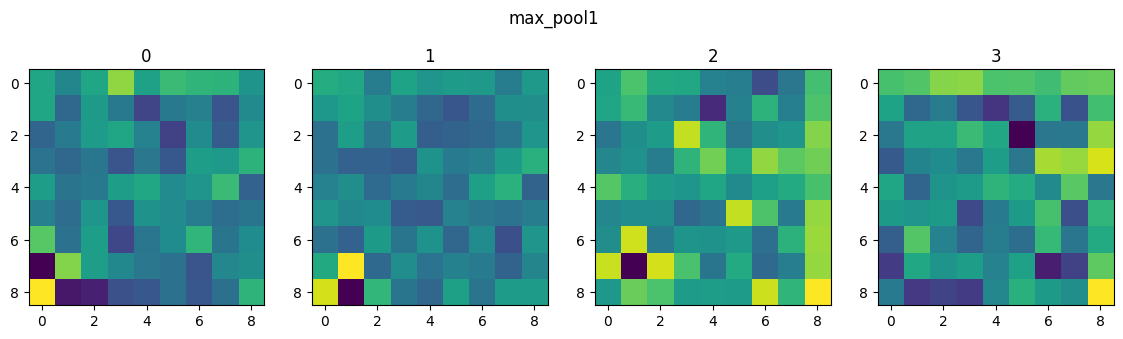

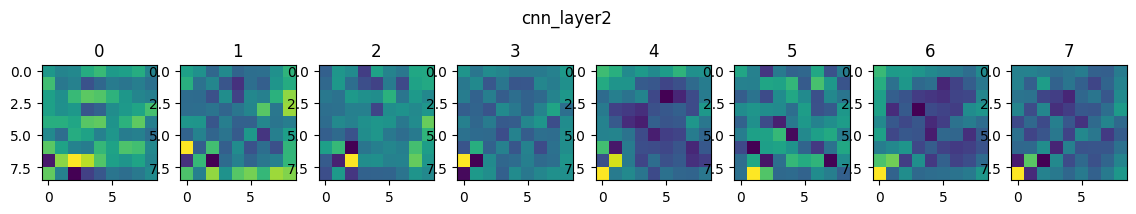

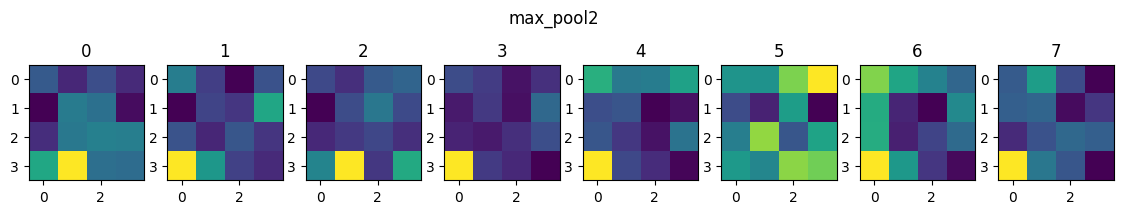

extracting: Conv2d
extracting: MaxPool2d
extracting: Conv2d
extracting: MaxPool2d
extracting: LogSoftmax


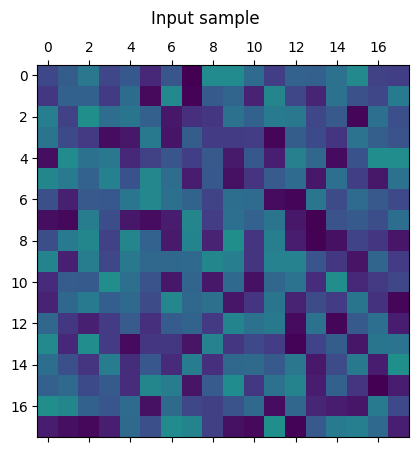

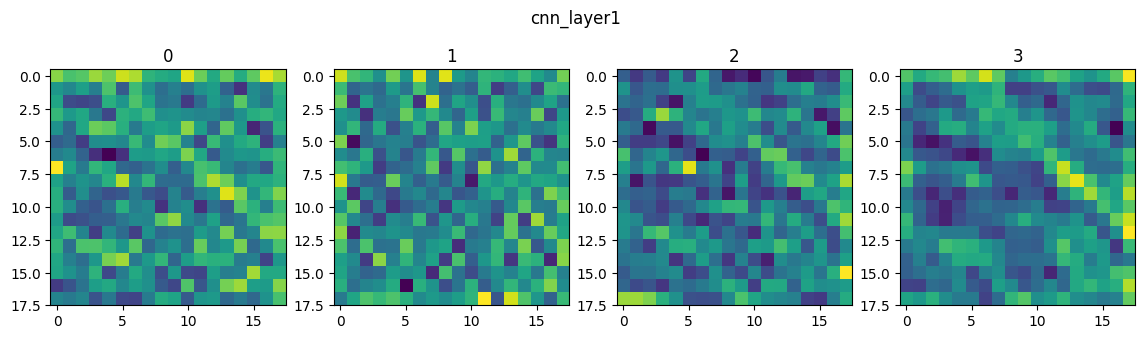

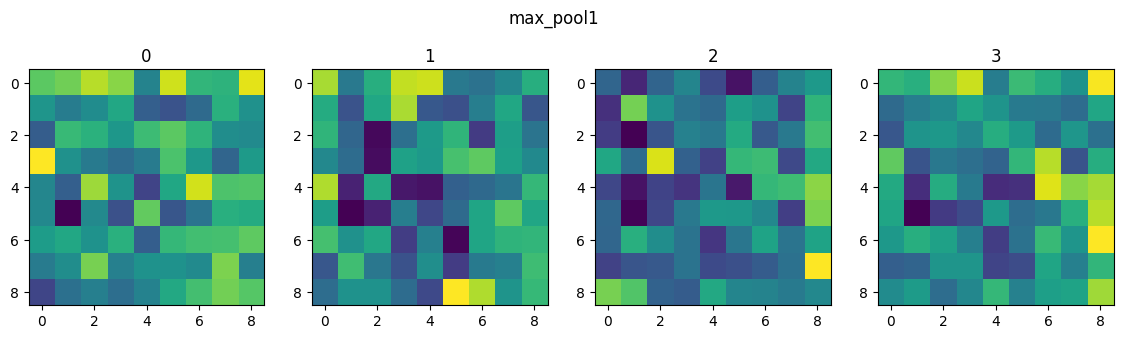

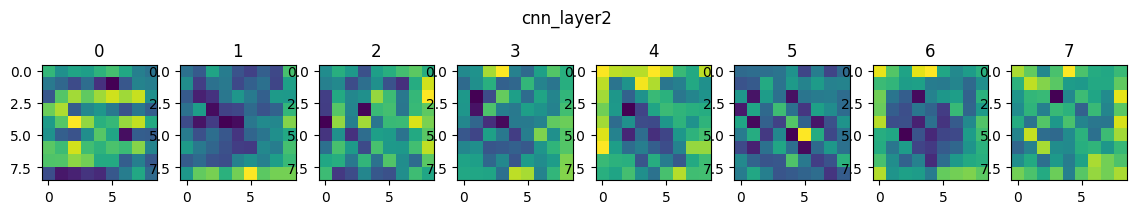

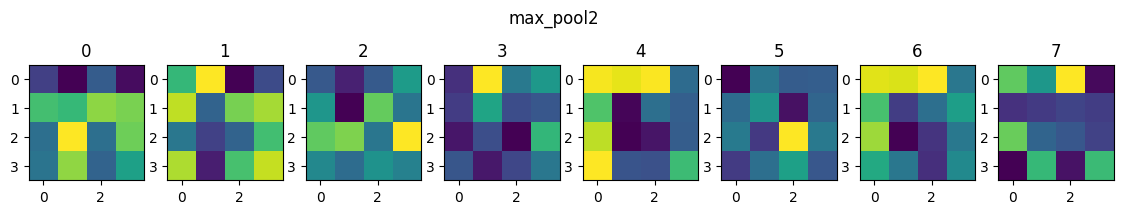

In [189]:
samples = [X[0], X[15], X[25]]
for sample in samples:
    # generate activations only for Conv2d and MaxPool2d layers
    output_features = model.extract_features(sample.unsqueeze(dim=0).unsqueeze(dim=0).to(device))
    display_feature_maps(sample, output_features)

In [202]:
#probe_sample = X[3].unsqueeze(dim=0).unsqueeze(dim=0)
probe_sample = X.unsqueeze(dim=0).unsqueeze(dim=0)
probe_sample = probe_sample.view(-1, 1, 18, 18)
#probe_sample = probe_sample[0,:,:,:].to(device)
print(probe_sample.shape)
output_features = model.extract_features(probe_sample.to(device))
# preds = model(probe_sample.to(device))
tested_features = output_features["cnn_layer2"]
print("tested features shape: ", tested_features.shape)

# feed forward to classifier group
#preds = model.classify_features_activations(tested_features)
preds = output_features["output_activation"]
print("preds shape: ", preds.shape)
print("preds: ", preds)
top_class_id = torch.argmax(preds, dim=1)
print('id: ', top_class_id)
top_class_channel = preds[:, id]
print("shape of top_class_channel: ", top_class_channel)
# calc grad
top_class_channel.requires_grad_()
grads = torch.autograd.grad(top_class_channel, tested_features)[0]
print("grads shape: ", grads.shape)

pooled_grads = torch.mean(grads, axis=(0, 2, 3))
print("p grads shape: ", pooled_grads.shape)
for i in range(pooled_grads.shape[-1]):
    tested_features[0, i, :, :] *= pooled_grads[i]
print("tested features shape in the end: ", tested_features.shape)
heatmap = torch.mean(tested_features, axis=1).squeeze()
print("heatmap shape: ", heatmap.shape)
print("heatmap: ", heatmap)


heatmap = torch.maximum(heatmap, torch.tensor(0))
heatmap /= torch.max(heatmap)

plt.matshow(probe_sample.detach().numpy().squeeze().squeeze())
plt.matshow(heatmap.to("cpu").squeeze().detach().numpy())

torch.Size([100, 1, 18, 18])
extracting: Conv2d
extracting: MaxPool2d
extracting: Conv2d
extracting: MaxPool2d
extracting: LogSoftmax
tested features shape:  torch.Size([100, 8, 9, 9])
preds shape:  torch.Size([100, 3])
preds:  tensor([[   0.0000, -248.6645, -416.7224],
        [   0.0000, -293.2806, -439.7957],
        [   0.0000, -310.0470, -494.6394],
        [   0.0000, -245.4278, -453.1904],
        [   0.0000, -258.9330, -387.1738],
        [   0.0000, -260.7305, -434.4512],
        [   0.0000, -222.9232, -369.1512],
        [   0.0000, -335.4554, -481.8996],
        [   0.0000, -281.7125, -415.9325],
        [   0.0000, -241.9561, -423.7521],
        [   0.0000, -257.3996, -345.3515],
        [   0.0000, -325.7044, -459.1916],
        [   0.0000, -268.7907, -343.7986],
        [   0.0000, -277.1279, -395.7627],
        [   0.0000, -299.4332, -431.6710],
        [   0.0000, -251.5262, -376.1465],
        [   0.0000, -302.3981, -392.6409],
        [   0.0000, -282.3896, -343.9074]

RuntimeError: grad can be implicitly created only for scalar outputs